# Risk management

Risk management is a crucial part of asset management. We need to think about risk when putting together portfolios of stocks and bonds, options and futures, or even portfolios of managers, such as ETFs, mutual funds, and hedge funds. Financial assets all have their own unique risk profiles. For example the chapter on factor models gives you a sense how we can measure risk in equity portfolios. The focus there, though, is on the economic factors that lead to risk. This chapter will focus more on the statistical properties of asset returns.

To do this, we'll look at **return distributions** and how to measure them. We sometimes assume that asset returns are **normally distributed**. This is not true in many cases. 

We'll also learn about other risk measures, like **value-at-risk (VaR)** and **conditional value-at-risk (CVaR)**. All of these topics are covered in our Datacamp assignments, such as *Intro to Portfolio Risk Management in Python* and *Quantitative Risk Management in Python*.

Finally, our textbook covers many of these topics. As our author comments on pg. 397,

> A large number of important financial models, like modern or mean-variance portfolio theory (MPT) and the capital asset pricing model (CAPM), rest on the assumption that returns of securities are normally distributed. Therefore, this
> chapter presents approaches to test a given time series for normality of returns.

These topics are covered across a few different chapters. I wish that they covered more.

## Textbook Highlights

| Topic         | Pages  |
| :-------------------------------------------------------------------------------------- | :--------- | 
| **Normality Tests**. We do we mean by normally distributed? How do we measure this? Why is it important?      | Chapter 13. 399 - 415      | 
| **Value-at-Risk**. A very common way to look at the overall risk of a portfolio. | Chapter 12. 383 - 388    | 

## Getting set-up

Let's bring in our usual set of stock and ETF prices and make some log returns. 

In [1]:
# Set-up

import numpy as np
import pandas as pd
import math
import scipy.stats as scs
import statsmodels.api as sm
from pylab import mpl, plt

# seaborn
import seaborn as sns

from scipy.stats import norm

import numpy.random as npr  

import quantstats as qs

import janitor
from janitor import clean_names

from sstudentt import SST

# Keeps warnings from cluttering up our notebook. 
import warnings
warnings.filterwarnings('ignore')

# Some plot options that will apply to the whole workbook
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'


# Read in some eod prices
stocks = pd.read_csv('https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/main/data/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)  

stocks.dropna(inplace=True)  

stocks = clean_names(stocks)

rets_log = np.log(stocks / stocks.shift(1))  

rets_log.dropna(inplace=True)  



## Statistical tests for non-normality

We've already see some measures for non-normality. 

- Skewness (b) is a measure of asymmetry
- Kurtosis (k) is a measure of heavy-tailedness
- Skewness and kurtosis of normal are 0 and 3, respectively. The function used below gives **excess kurtosis**, where we subtract 3 from actual kurtosis.

Why do we care about this? When you're trading or forming portfolios of securities, you want to understand how the securities that you own might behave. Will their returns surprise me? How bad is my downside? What's my upside?

Of course, this is very difficult to know in practice. But, we can model stock returns and other assets the best we can. We can then, maybe, start to **quantify our risk**. 

In the code below, `axis = 0` means to calculate our skewness and kurtosis by row. 

In [2]:
rets_log.describe()

,aapl_o,msft_o,intc_o,amzn_o,gs_n,spy,_spx,_vix,eur=,xau=,gdx,gld
count,2137.000000,2137.000000,2137.000000,2137.000000,2137.000000,2137.000000,2137.000000,2137.000000,2137.000000,2137.000000,2137.000000,2137.000000
mean,0.000843,0.000542,0.000406,0.001189,0.000113,0.000408,0.000410,-0.000103,-0.000098,0.000052,-0.000356,0.000036
std,0.015908,0.014214,0.014909,0.019463,0.016609,0.009331,0.009355,0.077360,0.005931,0.010126,0.023742,0.010198
min,-0.131875,-0.121033,-0.095432,-0.135325,-0.136863,-0.067341,-0.068958,-0.350588,-0.026531,-0.088787,-0.113900,-0.091905
25%,-0.006907,-0.006768,-0.007765,-0.008254,-0.008340,-0.003424,-0.003326,-0.041878,-0.003588,-0.005048,-0.013647,-0.005097
50%,0.000666,0.000308,0.000569,0.000974,0.000422,0.000580,0.000559,-0.005233,0.000077,0.000232,-0.000220,0.000343
75%,0.009551,0.007865,0.008445,0.011636,0.009041,0.005058,0.004995,0.035181,0.003254,0.005426,0.013026,0.005303
max,0.085022,0.099413,0.100315,0.146225,0.090485,0.045450,0.046317,0.768245,0.030352,0.046867,0.106546,0.047953


In [3]:
rets_log.skew(axis = 0)

aapl_o   -0.235263
msft_o   -0.091231
intc_o    0.096828
amzn_o    0.181703
gs_n     -0.549177
spy      -0.522260
_spx     -0.514292
_vix      1.127393
eur=     -0.052486
xau=     -0.596764
gdx      -0.090202
gld      -0.599760
dtype: float64

In [4]:
rets_log.kurtosis(axis = 0)

aapl_o    4.803682
msft_o    7.310963
intc_o    3.928818
amzn_o    8.017345
gs_n      5.227209
spy       4.537738
_spx      4.705455
_vix      7.596355
eur=      1.521719
xau=      5.387749
gdx       1.582735
gld       5.700361
dtype: float64


Looks like Amazon (AMZN) has the "fattest tails". The VIX as the next highest excess kurtosis. 

But, how do you perform a statistical test for normality? In other words, we can measure skewness and kurtosis, but how can know if it is **statistically different** from a normal distribution?

There are several different statistical tests for this. Let's start with the **Shapiro-Wilk** test. The null hypothesis of the Shapiro-Wilk test is that the data are normally distributed. For fun, let's start by creating 100 random numbers from a normal distribution and see what this test tells us. We are using `scs.shapiro()`.

This gives us a **formal test**, rather than just a graph, for asymmetrical distributions and/or heavy tails.

You can read more about the actual statistics [here](https://en.wikipedia.org/wiki/Shapiro–Wilk_test).


In [5]:
from numpy.random import seed
from numpy.random import randn

#set seed (e.g. make this example reproducible)
seed(23)

#generate dataset of 100 random values that follow a standard normal distribution
data = randn(100)

scs.shapiro(data)

ShapiroResult(statistic=0.992075502872467, pvalue=0.8266684412956238)

See that p-value? As a general rule, we're looking for a value less than 0.10 or 0.05 in order to "reject" the null hypothesis that the data are normally distributed. Good thing we can't reject that hypothesis here! we know that the data are from the normal distribution. 

The analogy that I always use: distributions are hats that contain numbers. We can pull numbers out of that hat. If we pull enough numbers, we'll get the underlying distribution that is generating the values in our hat. There are many different types of distributions!

Now, let's look at our actual returns. We need to pull out the returns, one column at a time, for the `scs.shapiro()` function. So, we'll look at Apple.

In [6]:
scs.shapiro(rets_log['aapl_o'])

ShapiroResult(statistic=0.9554497003555298, pvalue=4.829840828298972e-25)

Yeah, that's not a normal distribution! Let's look at things graphically, using material from the financial time series chapter. I have overlayed normal distribution that has the same mean and standard deviation as Apple's returns. So, any differences are being caused by skewness and kurtosis. 

<AxesSubplot:xlabel='aapl_o'>

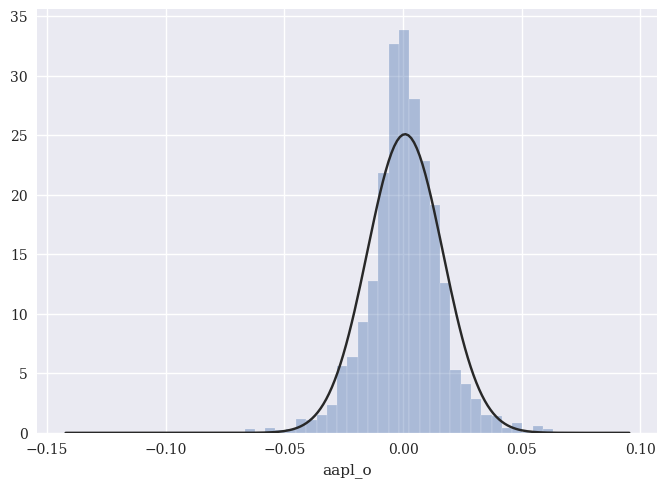

In [7]:
sns.distplot(rets_log['aapl_o'], fit=norm, kde=False)

You can see how Apple's daily returns are **not normally distributed**. There are too many observations in the middle (i.e. lots of small daily returns), not enough observations in the middle ranges (i.e. the normal distribution curve is above the histogram), and too many extreme observations in the tail. 

There's also the **Jarque-Bera test**, which gets at the same thing. This test compares the skewness and kurtosis of your data with theoretical normal values (0 and 3). You can read more [here](https://en.wikipedia.org/wiki/Jarque–Bera_test).

In [8]:
scs.jarque_bera(rets_log['aapl_o'])

Jarque_beraResult(statistic=2062.363018375023, pvalue=0.0)

We again look at the p-value and can reject the null hypothesis that Apple's returns are normally distributed.

Finally, we have the **Anderson-Darling test**. You can read more about it [here](https://en.wikipedia.org/wiki/Anderson–Darling_test).

In [9]:
scs.anderson(rets_log['aapl_o'])

AndersonResult(statistic=16.873944813207345, critical_values=array([0.575, 0.655, 0.786, 0.916, 1.09 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

These results look a bit different, but are conceptually similar. The test statistic is 16.87. If we want a 1% significance-level, we compare that to 1.09. Since the test statistic is greater than the critical value of 1.09 at a 1% significance-level, we can reject the null hypothesis that the data are normally distributed.

We we can also use something called a **qq-plot** to visualize how a set of returns compares the the theoretical normal distribution. I'm using `sm.qqplot` to make the graph.

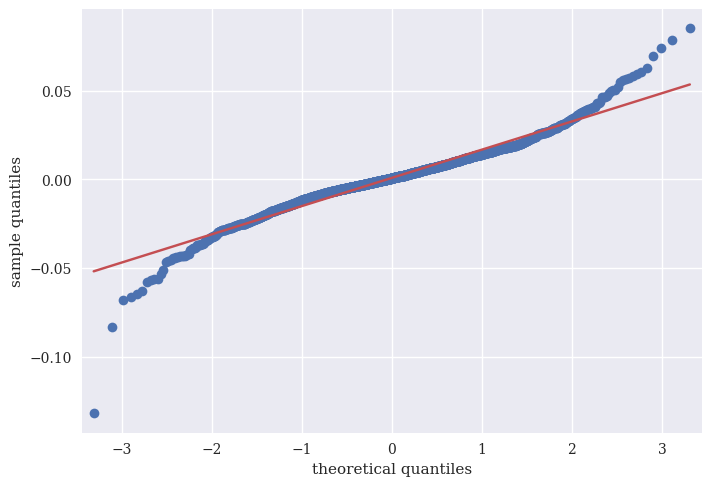

In [10]:
sm.qqplot(rets_log['aapl_o'], line='s')
plt.xlabel('theoretical quantiles')
plt.ylabel('sample quantiles');

Where the blue deviates from the red, we are seeing more extreme values than the normal distribution would predict. In other words, **excess kurtosis**.

## Fitting different distributions

There are a lot of different types of distributions for different types of data. In finance, we often assume that the real data that we're observing, like stock returns, comes from a certain type of distribution. Here are some examples: the Standard Normal, the Normal, a Chi Square, and a Poisson. Note how a Poisson distribution is useful for discrete, counting data. 


In [11]:
sample_size = 500
rn1 = npr.standard_normal(sample_size)  
rn2 = npr.normal(100, 20, sample_size)  
rn3 = npr.chisquare(df=0.5, size=sample_size)  
rn4 = npr.poisson(lam=1.0, size=sample_size)  

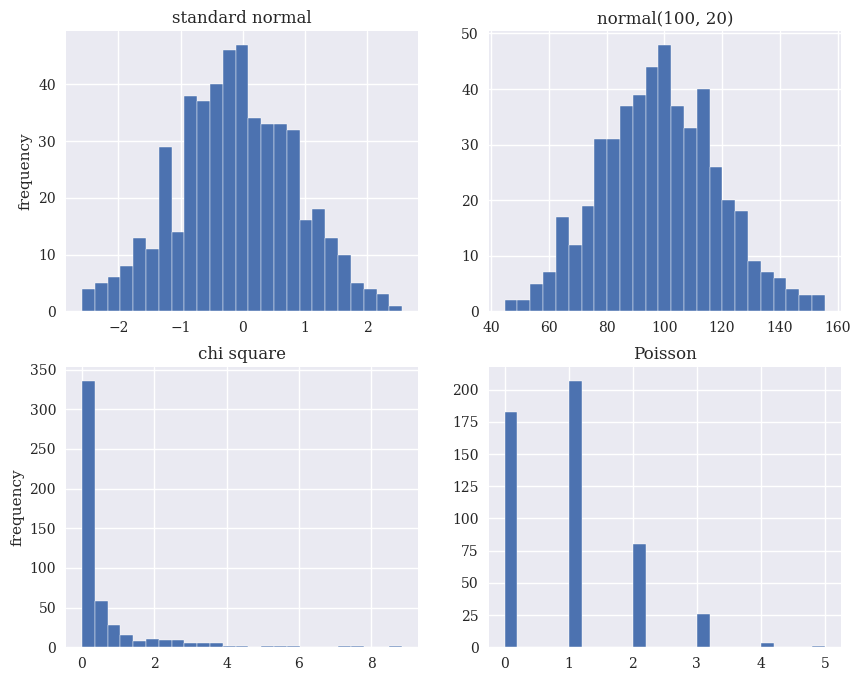

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,
                                             figsize=(10, 8))
ax1.hist(rn1, bins=25)
ax1.set_title('standard normal')
ax1.set_ylabel('frequency')
ax2.hist(rn2, bins=25)
ax2.set_title('normal(100, 20)')
ax3.hist(rn3, bins=25)
ax3.set_title('chi square')
ax3.set_ylabel('frequency')
ax4.hist(rn4, bins=25)
ax4.set_title('Poisson');

Some distributions to a better job than others describing real financial data. One distribution that we commonly see is called the $t$-distribution. This distribution has "fatter" tails than a normal distribution with smaller sample sizes, so it can better match what we actually observe. You can read more [here](https://www.investopedia.com/terms/t/tdistribution.asp). 

We can use the `scipy.stats` library to find functions that take data and **fit a particular distribution** to it. What does this mean? Remember how a normal distribution is described completely by the mean and standard deviation of your data? In other words, if you know the mean and standard deviation, then you can draw that normal bell curve? That's what I did in the Apple return histogram above.


In [13]:
n_params = scs.norm.fit(rets_log['aapl_o'])
n_params

(0.0008426947352013821, 0.015904383367899087)

Look back at the descriptives up above. I have fit a normal distribution to Apple and the function gave me the two necessary parameters to draw the distribution. They are the mean and standard deviation of Apple's returns.
I can take that mean and standard deviation and create a normal distribution that would describe Apple's daily returns **if they were normally distributed**. We know that they are not.

We can use `norm.pdf` to create the **probability distribution function**, or pdf, for a normal distribution with that mean and standard deviation. I first create an array *x*, that has numbers from -0.05 to 0.05 in 0.0005 increments. `norm.pdf` is taking a value from the array *x* and saying "What is the corresponding y-value, given the mean and standard deviation of this distribution?" A larger y-value means that the particular x-value is more likely. 

Note how the middle of the distribution is just slightly above zero. That's the mean daily return.

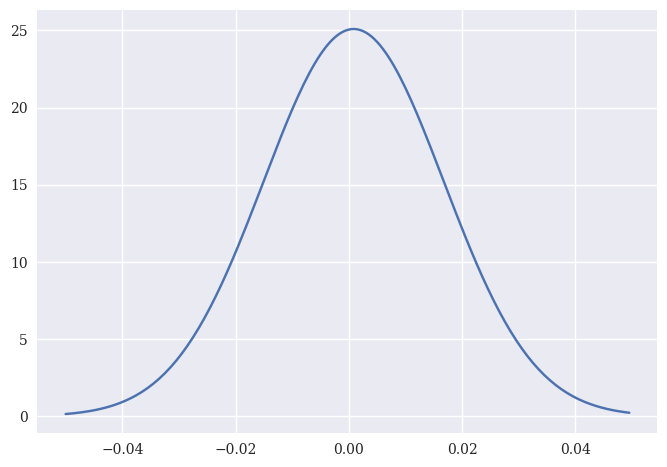

In [14]:
#x-axis ranges from -.05 and .05 with .0005 steps
x = np.arange(-.05, .05, 0.0005)

#plot normal distribution with Apple's mean and standard deviation from the fitted normal distribution
plt.plot(x, norm.pdf(x, n_params[0], n_params[1]));


We can do the same thing for a $t$-distribution. These are also bell-shaped, but with heavier tails. Kind of like stock returns.

In [15]:
t_params = scs.t.fit(rets_log['aapl_o']);
t_params

(3.8903663979713157, 0.0009572226500936301, 0.011356044925912068)

Here I have three parameters. The first is the **degrees-of-freedom** (df), which describes how heavy the tails are. The other two paramters are called **loc** and **scale**, respectively. As df grows larger, the distribution will approach the normal distribution.

I can again use the parameters for the distribution to create the probability distribution function. 

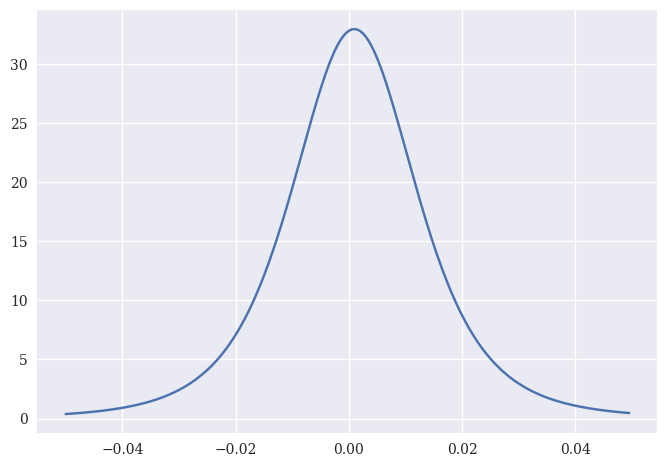

In [16]:
plt.plot(x, scs.t.pdf(x, t_params[0], t_params[1], t_params[2]));

We can plot both distributions on top of each other to see the difference. Remember, both of these are created using **actual Apple daily returns**. Which one looks more like the histogram of actual returns?

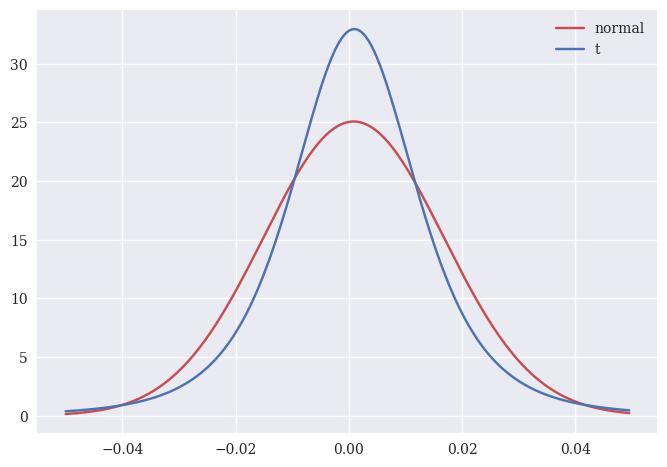

In [17]:
x = np.arange(-0.05, 0.05, 0.0005)

p1 = norm.pdf(x, n_params[0], n_params[1])
p2 = scs.t.pdf(x, t_params[0], t_params[1], t_params[2])

plt.plot(x, p1, color='r', label='normal')
plt.plot(x, p2, color='b', label='t')

plt.legend();


## Risk management and tail risk

We can use these ideas of distributions to think about **risk management**. **Tail risk** is the risk of extreme investment outcomes, most notably on the negative side of a distribution. Our various Datacamp lectures cover different measures of tail risk, including historical drawdown, Value-at-Risk (VaR), Conditional Value-at-Risk (also called Expected Shortfall), and some basic Monte Carlo simulations. The text also discusses VaR and Monte Carlo.



### Value at Risk

Value-at-Risk, or VaR, is a threshold with a given confidence level that losses will not (or more accurately, will not historically) exceed a certain level. VaR is commonly quoted with
quantiles such as 95, 99, and 99.9. Some key points:

- Consider the distribution of losses over a fixed time period (day, week, etc.)
- $\alpha$-VaR is the 𝛼-quantile of the loss distribution
- $\alpha$- known as confidence level (e.g. 95%, 99%)
- Should lose no more than $\alpha$--VaR with probability $\alpha$

In its most general form, VaR measures the potential loss in value of a risky asset or portfolio over a defined period for a given confidence interval. Thus, if the VaR on an asset is $100 million at a one-week, 95% confidence level, there is a only a 5% chance that the value of the asset will drop more than $100 million over any given week.

In 1995, J.P. Morgan provided public access to data on the variances of and covariances across various security and asset classes, that it had used internally for almost a decade to manage risk, and allowed software makers to develop software to measure risk. It titled the service “RiskMetrics” and used the term “Value-at-Risk” to describe the risk measure that emerged from the data. Now, software like Bloomberg lets you easily calculate various VaR-like measures for your portfolio.

We can put some simple numbers on these ideas. We'll start with **parametric VaR**. This means making assumptions about the distribution of our returns. Let’s assume that our portfolio returns are normally distributed. If you move 1.65 standard deviations away from the mean, then 5% of your return observations are to your left. This return is your 5% VaR. Given our assumptions, on 5% of days, you lose at least this amount. To find the 99% VaR, you would move 2.326 standard deviations from the mean.

For example, we can use our 1-$\alpha$ threshold and the `norm.ppf` function to find how many standard deviations away from the mean in a normal distribution we have to move to have 1-$\alpha$ observations to the left of that point.


In [18]:
z = norm.ppf(0.05)
z

-1.6448536269514729

There's our 1.65. We can then easily find our VaR, assuming that Apple's returns are normally distributed.

In [19]:
-(rets_log['aapl_o'].mean() + z*rets_log['aapl_o'].std())

0.025323810900439656

VaR is usually given as a positive number, so I put a negative sign out in front. This is saying that you would expect to lose at least 2.5% on Apple on any given day 5% of the time. Again, assuming that Apple's returns are normally distributed, which they are not!

Here's another example of parametric VaR using code from Datacamp. We'll again use the 95% threshold, so $\alpha$ is 5%. 

In [20]:
mu = np.mean(rets_log['aapl_o'])
std = np.std(rets_log['aapl_o'])
confidence_level = 0.05
VaR_95 = norm.ppf(confidence_level, mu, std)
-VaR_95

0.02531768793191412

This time, `norm.ppf` is moving to the left in a normal distribution with Apple's mean and standard deviation, so that 5% of the observations are to the left of the point and 95% are to the right. It is then telling us the return that lies at this point. The differences are due to rounding.

Let's plot the VaR on the normal distribution that we fit with Apple's returns.


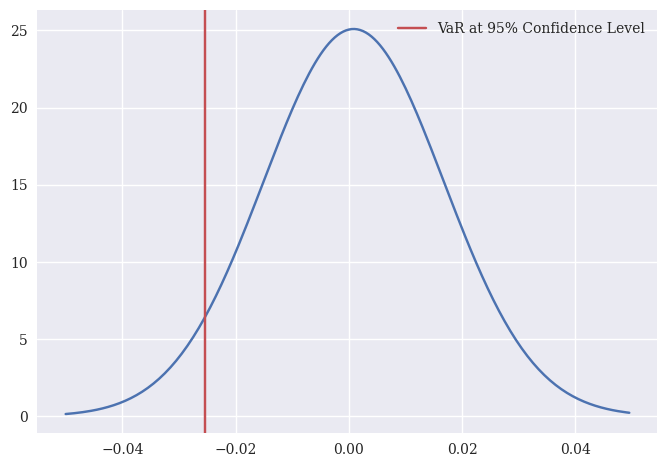

In [21]:
plt.plot(x, norm.pdf(x, n_params[0], n_params[1]))
plt.axvline(x = VaR_95, c='r', label = "VaR at 95% Confidence Level")
plt.legend();


As the Datacamp notes, we can scale VaR with the square root of time. So, a daily VaR can be converted into a weekly VaR.

In [22]:
-VaR_95*np.sqrt(5)

0.056612071248886044


We can also calculate something called **non-parametric VaR**. A simple way to estimate VaR is to line up past returns, sort them by magnitude, and find a return that has 5% worse days and 95% better days. This is one way to find the 95% VaR, since, if history repeats itself, you will lose less than this number with 95% certainty. So, we are still using history as our guide, but without a distributional assumption like normality.

Here's an example from our textbook that shows this VaR for different confidence levels using just Apple's historical returns.


In [23]:
percs = [0.01, 0.1, 1., 2.5, 5.0, 10.0]
var = scs.scoreatpercentile(rets_log['aapl_o'], percs)
print('%16s %16s' % ('Confidence Level', 'Value-at-Risk'))
print(33 * '-')
for pair in zip(percs, var):
    print('%16.2f %16.3f' % (100 - pair[0], -pair[1]))

Confidence Level    Value-at-Risk
---------------------------------
           99.99            0.121
           99.90            0.068
           99.00            0.043
           97.50            0.031
           95.00            0.025
           90.00            0.017


So, 1% of the time, or 1 out of every 100 days, we would expect to lose **at least** 4.3%. That **at least** is really important.

Here's some other code that does the same thing. I got this from the Datacamp.

In [24]:
var_level = 99
var_99 = np.percentile(rets_log['aapl_o'], 100 - var_level)
-var_99

0.043116672339112976

There's that 4.3% again.

We can also plot the histogram of Apple's returns with the non-parametric VaR.

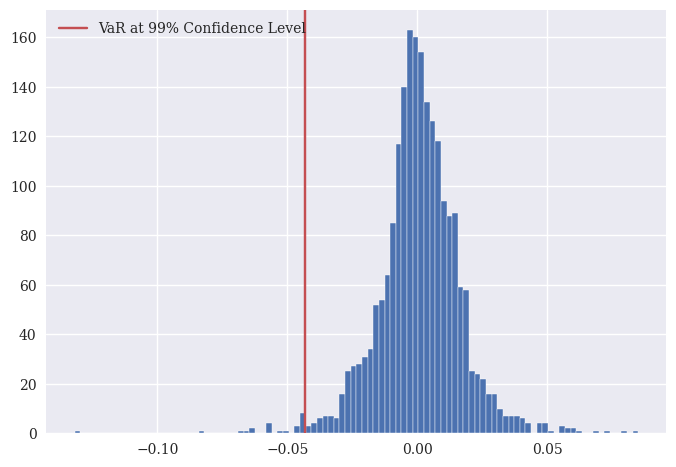

In [25]:
plt.hist(rets_log['aapl_o'], bins = 100)
plt.axvline(x = var_99, c='r', label = "VaR at 99% Confidence Level")
plt.legend();

### Conditional VaR

Conditional Value at Risk, or CVaR, is an estimate of **expected losses** sustained in the worst 1 - $\alpha$% of scenarios. CVaR is also commonly quoted
with quantiles such as 95, 99, and 99.9.

- You will also see it called Tail VaR (TVaR), or **expected shortfall (ES)**
- $\alpha$-ES is expected loss **given** that loss exceeds $\alpha$-VaR
- This is the **expected** (or average) loss on a really bad day. It takes into account the returns to the left of the VaR, so it will exceed it.

Note that ES > VaR. This is the **expected return** on a bad day, so it is the average of all of the returns to the left of the 1-$\alpha$% VaR return.

Here's an example, using code from Datacamp, for a 99% CVaR using Apple's returns.

In [26]:
var_level = 99
var_99 = np.percentile(rets_log['aapl_o'], 100 - var_level)
cvar_99 = rets_log['aapl_o'][rets_log['aapl_o'] <= var_99].mean()
-cvar_99

0.05685084533762395

So, on a bad day, when Apple's VaR hits and exceeds the 99% threshold, you would expect to lose, on average, 5.69%.

Finally, note that we are also using a **non-parametric** method, since we are using the actual returns to find an average. There are no assumptions about the distribution of Apple returns here, expect for the one that says that Apple's historical returns are a good proxy for their future return distribution and, therefore, our estimate of Apple's risk.

### Rolling VaR with different distributions

Our Datacamp assignments cover using a $t$-distribution to find a **rolling VaR measure**. In other words, let's calculate the mean and standard deviation of Apple's returns as we go through time. We'll use a rolling 30-day period. With these values, we'll find the 95% VaR for Apple, assuming that their returns follow a $t$-distribution. 

What does this mean? First, the VaR will change as our estimates for Apple's mean and standard deviation of returns changes! Also, we'll be taking into account "fatter tails" when finding our VaR.

This is another **parametric VaR**.

In the Python itself, there's some fancier stuff going on. We've seen the `rolling()` part. That just looks back 30 periods (a 30 day window in this case) to calculate the value.

But, what is going on in that *rolling_parameters* definition? First, this is a **list**. You cans ee that by looking down in the Jupyter variables window. Specifically a list of **tuples**, where each tuple contains three values. The first value of each tuple is 29. The second is the ith value of the rolling means. The second is the sth value of the rolling standard deviations. These will be `nan`, or missing, until we hit the 30th observation in the data (or, the way Python counts, the 29th). The `enumerate()` function keeps track of the number of items in *sigma*. I would have never come up with that exact code to do this. 

Why do we need *rolling_parameters*? These go into the VaR calculation. Every day, we calculate a new VaR using the next set of rolling parameters. What are the parameters for? The $t$-distribution. The three values that define a specific the $t$-distribution (i.e. that draw the graph) are degrees-of-freedom (df), loc, and scale. From the Datacamp lecture:

> One special characteristic of the T distribution is its degrees of freedom. 
> The number of degrees of freedom is the number of independent observations. The degrees of freedom number affects the shape of the T distribution. 
> It can be explicitly set with the `df' parameter, or estimated using the ".fit()" method of the "scipy.stats.t" distribution.

So, you would change that *df* value based on your window.

Like in the DataCamp, we'll assume that we have a portfolio of \$100,000. In fact, VaR is often given in **dollar terms**. What is the minimum amount that we would expect to lose on a bad day?

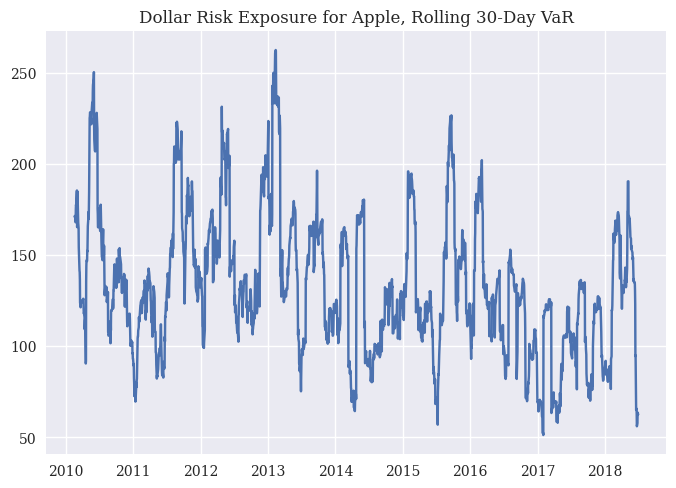

In [27]:
# Create rolling window parameter list
mu = rets_log['aapl_o'].rolling(30).mean()
sigma = rets_log['aapl_o'].rolling(30).std()
rolling_parameters = [(29, mu[i], s) for i, s in enumerate(sigma)]

# Compute the 95% VaR array using the rolling window parameters
VaR_95 = np.array([scs.t.ppf(0.95, *params) 
                    for params in rolling_parameters])

plt.plot(rets_log['aapl_o'].index, 0.05 * VaR_95 * 100000)
plt.title('Dollar Risk Exposure for Apple, Rolling 30-Day VaR');


## QuantStats

Finally, there are some fun Python packages to automate all of this. Here's some examples of one called **QuantStats**. You can download it the usual way in the terminal: `pip install QuantStats`

You can find some basic documentation [here](https://pypi.org/project/QuantStats/).

One fun thing: It has a `qs.extend_pandas()` function that let's you call QuantStat functions directly on a DataFrame, like you would a `pandas` function.

Let's find the Sharpe ratio for Apple.

In [28]:
qs.extend_pandas()

stock = rets_log['aapl_o']

qs.stats.sharpe(stock)

0.8409149595522958

Here's the Sharpe again, but using the `pandas` extention feature. **stock** contains Apple's returns.

In [29]:
stock.sharpe()

0.8409149595522958

Some nice performance graphs.

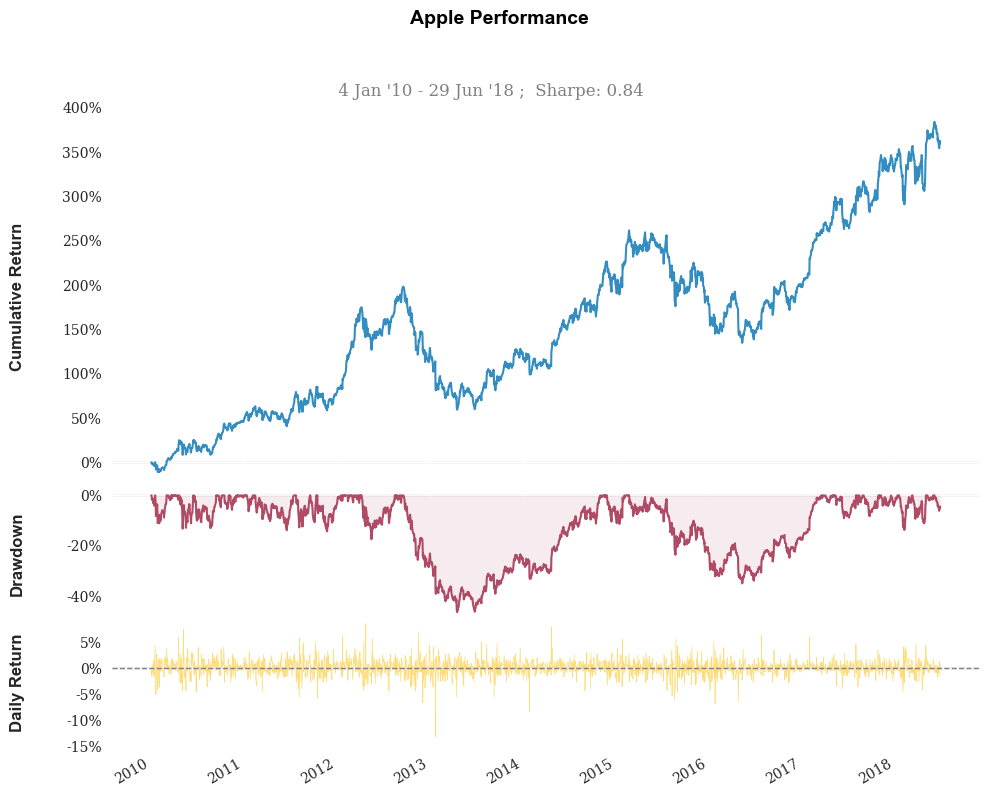

In [30]:
stock.plot_snapshot(title='Apple Performance')

Finally, this will create a giant performance report as an HTML file. You could backtest a strategy and then generate a report using this too.

In [31]:
#qs.reports.html(stock, "SPY")